In [1]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "07_training/07c_export.ipynb"
_nb_title = "Saving model state"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Saving model state&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F07_training%2F07c_export.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F07_training%2F07c_export.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/07_training/07c_export.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/07_training/07c_export.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/07_training/07c_export.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Saving model state

In this notebook, we checkpoint and export the model.

## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
print('TensorFlow version' + tf.version.VERSION)
print('Built with GPU support? ' + ('Yes!' if tf.test.is_built_with_cuda() else 'Noooo!'))
print('There are {} GPUs'.format(len(tf.config.experimental.list_physical_devices("GPU"))))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## Training code

This is the original code, from [../06_preprocessing/06e_colordistortion.ipynb](../06_preprocessing/06e_colordistortion.ipynb)
modified to use the most efficient ingest as determined in [./07a_ingest.ipynb](./07a_ingest.ipynb).

In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'    

from tensorflow.data.experimental import AUTOTUNE

IMG_HEIGHT = 448 # note *twice* what we used to have
IMG_WIDTH = 448
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])
    
class _Preprocessor:    
    def __init__(self):
        # nothing to initialize
        pass
    
    def read_from_tfr(self, proto):
        feature_description = {
            'image': tf.io.VarLenFeature(tf.float32),
            'shape': tf.io.VarLenFeature(tf.int64),
            'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        rec = tf.io.parse_single_example(
            proto, feature_description
        )
        shape = tf.sparse.to_dense(rec['shape'])
        img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
        label_int = rec['label_int']
        return img, label_int
    
    def read_from_jpegfile(self, filename):
        # same code as in 05_create_dataset/jpeg_to_tfrecord.py
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
    def preprocess(self, img):
        return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)

# most efficient way to read the data
# as determined in 07a_ingest.ipynb
# splits the files into two halves and interleaves datasets
def create_preproc_dataset(pattern):
    """
    Does interleaving, parallel calls, prefetch, batching
    Caching is not a good idea on large datasets.
    """
    preproc = _Preprocessor()
    files = [filename for filename in tf.io.gfile.glob(pattern)]
    if len(files) > 1:
        print("Interleaving the reading of {} files.".format(len(files)))
        def _create_half_ds(x):
            if x == 0:
                half = files[:(len(files)//2)]
            else:
                half = files[(len(files)//2):]
            return tf.data.TFRecordDataset(half,
                                          compression_type='GZIP')
        trainds = tf.data.Dataset.range(2).interleave(
            _create_half_ds, num_parallel_calls=AUTOTUNE)
    else:
        trainds = tf.data.TFRecordDataset(files,
                                         compression_type='GZIP')
    def _preproc_img_label(img, label):
        return (preproc.preprocess(img), label)
    
    trainds = (trainds
               .map(preproc.read_from_tfr, num_parallel_calls=AUTOTUNE)
               .map(_preproc_img_label, num_parallel_calls=AUTOTUNE)
               .shuffle(200)
               .prefetch(AUTOTUNE)
              )
    return trainds

def create_preproc_image(filename):
    preproc = _Preprocessor()
    img = preproc.read_from_jpegfile(filename)
    return preproc.preprocess(img)

class RandomColorDistortion(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.5, 1.5], 
                 brightness_delta=[-0.2, 0.2], **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
    
    def call(self, images, training=None):
        if not training:
            return images
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        
        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        images = tf.clip_by_value(images, 0, 1)
        return images

## Training

Interleaving, parallel calls, prefetch, batching
Caching is not a good idea on large datasets.

In [3]:
#PATTERN_SUFFIX, NUM_EPOCHS = '-0000[01]-*', 3 # small
PATTERN_SUFFIX, NUM_EPOCHS = '-*', 20 # full

In [6]:
import os, shutil
shutil.rmtree('chkpts', ignore_errors=True)
os.mkdir('chkpts')

def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
    
    train_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book-data/flowers_tfr/train' + PATTERN_SUFFIX
    ).batch(batch_size)
    eval_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book-data/flowers_tfr/valid' + PATTERN_SUFFIX
    ).batch(batch_size)

    layers = [
      tf.keras.layers.experimental.preprocessing.RandomCrop(
          height=IMG_HEIGHT//2, width=IMG_WIDTH//2,
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          name='random/center_crop'
      ),
      tf.keras.layers.experimental.preprocessing.RandomFlip(
          mode='horizontal',
          name='random_lr_flip/none'
      ),
      RandomColorDistortion(name='random_contrast_brightness/none'),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]

    # checkpoint and early stopping callbacks
    model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath='./chkpts',
        monitor='val_accuracy', mode='max',
        save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', mode='max',
        patience=2)
    
    # model training
    model = tf.keras.Sequential(layers, name='flower_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(
                      from_logits=False),
                  metrics=['accuracy']
                 )
    print(model.summary())
    history = model.fit(train_dataset, 
                        validation_data=eval_dataset,
                        epochs=NUM_EPOCHS,
                        callbacks=[model_checkpoint_cb, early_stopping_cb]
                       )
    training_plot(['loss', 'accuracy'], history)
    return model


Interleaving the reading of 16 files.
Interleaving the reading of 2 files.
Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random/center_crop (RandomCr (None, 224, 224, 3)       0         
_________________________________________________________________
random_lr_flip/none (RandomF (None, 224, 224, 3)       0         
_________________________________________________________________
random_contrast_brightness/n (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_embedding (KerasLa (None, 1280)              2257984   
_________________________________________________________________
dense_hidden (Dense)         (None, 16)                20496     
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 2,278,565
Trainable pa

INFO:tensorflow:Assets written to: ./chkpts/assets


92/92 [==============================] - 110s 1s/step - loss: 0.8528 - accuracy: 0.6745 - val_loss: 0.6037 - val_accuracy: 0.7694
Epoch 2/20
92/92 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8408INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


92/92 [==============================] - 109s 1s/step - loss: 0.4583 - accuracy: 0.8408 - val_loss: 0.4975 - val_accuracy: 0.8187
Epoch 3/20
92/92 [==============================] - ETA: 0s - loss: 0.4120 - accuracy: 0.8637INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


92/92 [==============================] - 108s 1s/step - loss: 0.4120 - accuracy: 0.8637 - val_loss: 0.4640 - val_accuracy: 0.8368
Epoch 4/20
92/92 [==============================] - ETA: 0s - loss: 0.3705 - accuracy: 0.8678INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


92/92 [==============================] - 110s 1s/step - loss: 0.3705 - accuracy: 0.8678 - val_loss: 0.4413 - val_accuracy: 0.8394
Epoch 5/20
92/92 [==============================] - ETA: 0s - loss: 0.3076 - accuracy: 0.9005INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


92/92 [==============================] - 103s 1s/step - loss: 0.3076 - accuracy: 0.9005 - val_loss: 0.4257 - val_accuracy: 0.8420
Epoch 6/20
92/92 [==============================] - 98s 1s/step - loss: 0.3204 - accuracy: 0.8824 - val_loss: 0.4699 - val_accuracy: 0.8290
Epoch 7/20
92/92 [==============================] - ETA: 0s - loss: 0.3018 - accuracy: 0.8885INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


92/92 [==============================] - 105s 1s/step - loss: 0.3018 - accuracy: 0.8885 - val_loss: 0.4002 - val_accuracy: 0.8601
Epoch 8/20
92/92 [==============================] - 97s 1s/step - loss: 0.3073 - accuracy: 0.8920 - val_loss: 0.4380 - val_accuracy: 0.8316
Epoch 9/20
92/92 [==============================] - 96s 1s/step - loss: 0.2694 - accuracy: 0.9083 - val_loss: 0.4238 - val_accuracy: 0.8420


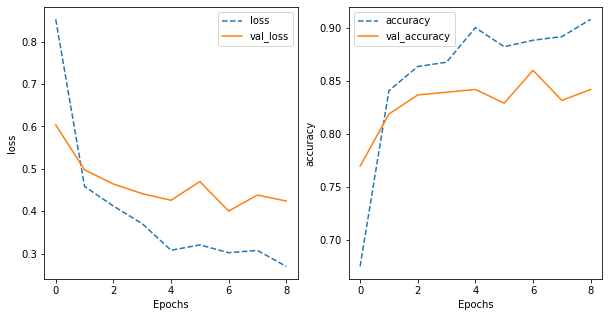

In [7]:
model = train_and_evaluate()

## Save model, then load it to make predictions

This way, we don't have to have the model in memory

In [8]:
import os, shutil
shutil.rmtree('export', ignore_errors=True)
os.mkdir('export')
model.save('export/flowers_model')

INFO:tensorflow:Assets written to: export/flowers_model/assets


INFO:tensorflow:Assets written to: export/flowers_model/assets


In [9]:
!ls export/flowers_model

assets	saved_model.pb	variables


In [10]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir export/flowers_model

The given SavedModel SignatureDef contains the following input(s):
  inputs['random/center_crop_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 448, 448, 3)
      name: serving_default_random/center_crop_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['flower_prob'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 5)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


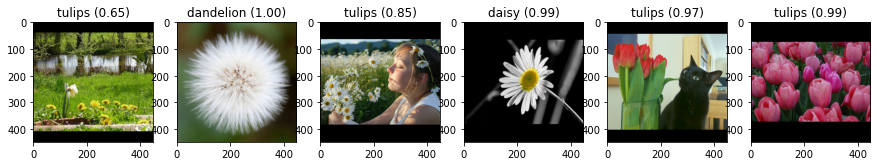

In [11]:
## for prediction, we won't have TensorFlow Records.
## this is how we'd predict for individual images
filenames = [
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/9158041313_7a6a102f7a_n.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/9299302012_958c70564c_n.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8733586143_3139db6e9e_n.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8713397358_0505cc0176_n.jpg'
]
serving_model = tf.keras.models.load_model('export/flowers_model')
input_images = [create_preproc_image(f) for f in filenames]
f, ax = plt.subplots(1, 6, figsize=(15,15))
for idx, img in enumerate(input_images):
    ax[idx].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = serving_model.predict(batch_image)
    pred = batch_pred[0]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx].set_title('{} ({:.2f})'.format(pred_label, prob))

## Serving signature

Expecting clients to do all this reshaping is not realistic.
Let's do two things:
(1) Define a serving signature that simply takes the name of a file
(2) Vectorize the code to accept a batch of filenames, so that we can do it all in one go.

In [12]:
## it's better to vectorize the prediction
filenames = tf.convert_to_tensor([
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/9158041313_7a6a102f7a_n.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/9299302012_958c70564c_n.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8733586143_3139db6e9e_n.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8713397358_0505cc0176_n.jpg'
])
print(filenames)
input_images = tf.map_fn(create_preproc_image, 
                         filenames, fn_output_signature=tf.float32)
batch_pred = serving_model.predict(input_images)
print('full probs:\n', batch_pred)
top_prob = tf.math.reduce_max(batch_pred, axis=[1])
print('top prob:\n', top_prob)
pred_label_index = tf.math.argmax(batch_pred, axis=1)
print('top cls:\n', pred_label_index)
pred_label = tf.gather(tf.convert_to_tensor(CLASS_NAMES), pred_label_index)
print(pred_label)

tf.Tensor(
[b'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg'
 b'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg'
 b'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/9158041313_7a6a102f7a_n.jpg'
 b'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/9299302012_958c70564c_n.jpg'
 b'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8733586143_3139db6e9e_n.jpg'
 b'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8713397358_0505cc0176_n.jpg'], shape=(6,), dtype=string)
full probs:
 [[2.6823607e-01 4.8136555e-02 5.4868287e-03 2.8972227e-02 6.4916837e-01]
 [2.0415138e-04 9.9979216e-01 1.2813257e-06 1.5974816e-06 8.5633030e-07]
 [1.1143294e-02 3.4207560e-03 1.2576616e-01 9.4575118e-03 8.5021234e-01]
 [9.8936355e-01 1.0371597e-02 2.5198135e-06 2.2552245e-04 3.6822410e-05]
 [2.3643917e-03 9.7660151e-05 9.8958099

In [13]:
@tf.function(input_signature=[tf.TensorSpec([None,], dtype=tf.string)])
def predict_flower_type(filenames):
    input_images = tf.map_fn(
        create_preproc_image,
        filenames,
        fn_output_signature=tf.float32
    )
    batch_pred = model(input_images) # same as model.predict()
    top_prob = tf.math.reduce_max(batch_pred, axis=[1])
    pred_label_index = tf.math.argmax(batch_pred, axis=1)
    pred_label = tf.gather(tf.convert_to_tensor(CLASS_NAMES), pred_label_index)
    return {
        'probability': top_prob,
        'flower_type_int': pred_label_index,
        'flower_type_str': pred_label
    }

shutil.rmtree('export', ignore_errors=True)
os.mkdir('export')
model.save('export/flowers_model',
          signatures={
              'serving_default': predict_flower_type
          })

INFO:tensorflow:Assets written to: export/flowers_model/assets


INFO:tensorflow:Assets written to: export/flowers_model/assets


In [14]:
serving_fn = tf.keras.models.load_model('export/flowers_model').signatures['serving_default']
filenames = [
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/9158041313_7a6a102f7a_n.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/9299302012_958c70564c_n.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8733586143_3139db6e9e_n.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8713397358_0505cc0176_n.jpg'
]
pred = serving_fn(tf.convert_to_tensor(filenames))
print(pred)
print('******')
print(pred['flower_type_str'].numpy())

{'flower_type_str': <tf.Tensor: shape=(6,), dtype=string, numpy=
array([b'tulips', b'dandelion', b'tulips', b'daisy', b'tulips', b'tulips'],
      dtype=object)>, 'probability': <tf.Tensor: shape=(6,), dtype=float32, numpy=
array([0.6491684 , 0.999876  , 0.85021234, 0.98936355, 0.9670178 ,
       0.9906522 ], dtype=float32)>, 'flower_type_int': <tf.Tensor: shape=(6,), dtype=int64, numpy=array([4, 1, 4, 0, 4, 4])>}
******
[b'tulips' b'dandelion' b'tulips' b'daisy' b'tulips' b'tulips']


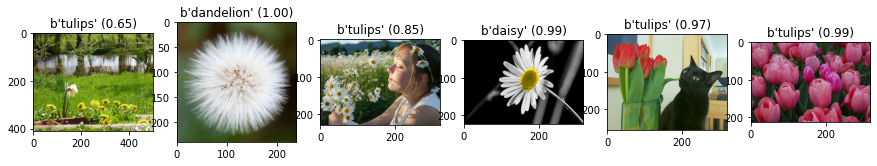

In [15]:
f, ax = plt.subplots(1, 6, figsize=(15,15))
for idx, (filename, prob, pred_label) in enumerate(
        zip(filenames, pred['probability'].numpy(), pred['flower_type_str'].numpy())):
    
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    ax[idx].imshow((img.numpy()));
    
    ax[idx].set_title('{} ({:.2f})'.format(pred_label, prob))    

## Save the model to Google Cloud Storage

Save the model so that it is available even after this Notebook instance is shutdown.
Change the BUCKET to be a bucket that you own.

In [5]:
%%bash
PROJECT=$(gcloud config get-value project)
BUCKET=${PROJECT}  # create a bucket with this name, or change to a bucket that you own.

gsutil cp -r export/flowers_model gs://${BUCKET}/flowers_5_trained

Copying file://export/flowers_model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://export/flowers_model/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://export/flowers_model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://export/flowers_model/variables/variables.index [Content-Type=application/octet-stream]...
/ [4 files][ 11.2 MiB/ 11.2 MiB]                                                
Operation completed over 4 objects/11.2 MiB.                                     


## License
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.